<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/BiLSTM/emo_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !git clone --branch BiLSTM https://github.com/ppkgtmm/emotion.git emotion

In [9]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, bilstm
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [11]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128,256])
hp.Choice('optimizer', ['amsgrad','adam'])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
hp.Choice('lstm_units', [8, 16, 32, 64])
seed = 1234

In [5]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
969,i feel this book explains things well and is e...,joy
14603,i am really enjoying doing tai chi with a weap...,joy
12452,i feel sure it does,joy
16662,i could make just one person feel loved for ju...,love
17442,i feel i ve had more unhappy years than happy ...,sadness


In [6]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [7]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [8]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [12]:
tuner = BayesianOptimization( bilstm.build_lstm,
                              'val_accuracy',
                              16,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/bilstm_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                8768      
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
Total params: 1,928,870
Trainable params: 1,928,870
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=3)

INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/bilstm_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
max_len: 300
num_words: 15000
lstm_units: 64
Score: 0.9235294163227081
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
max_len: 300
num_words: 15000
lstm_units: 64
Score: 0.9220588207244873
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
max_len: 300
num_words: 15000
lstm_units: 64
Score: 0.9214706122875214


In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'amsgrad', 'conditions': [], 'values': ['amsgrad', 'adam'], 'ordered': False}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
lstm_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}


In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,005,126
Trainable params: 4,005,126
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 2s 13ms/step
Accuracy:	90.9%


              precision    recall  f1-score   support

       anger       0.91      0.90      0.91       406
        fear       0.91      0.81      0.85       356
         joy       0.93      0.93      0.93      1014
        love       0.82      0.78      0.80       246
     sadness       0.92      0.98      0.95       870
    surprise       0.78      0.73      0.76       108

    accuracy                           0.91      3000
   macro avg       0.88      0.86      0.87      3000
weighted avg       0.91      0.91      0.91      3000



<Figure size 432x288 with 0 Axes>

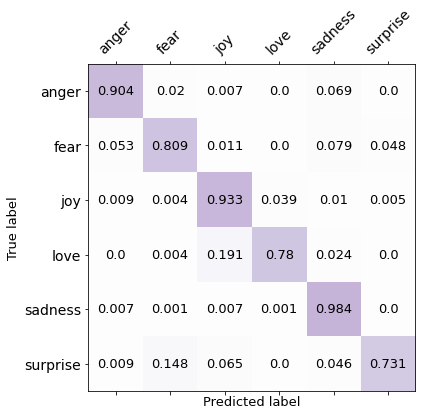

In [22]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [23]:
model = bilstm.build_lstm(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 4,005,126
Trainable params: 4,005,126
Non-trainable params: 0
_________________________________________________________________


In [24]:
cb = utils.get_callbacks('best_bilstm.h5')

In [25]:
history = model.fit(
    sequence_train, 
    target_train, 
    validation_split=0.1, 
    epochs=100,
    callbacks=cb
)

Epoch 1/100
479/479 [==============================] - 40s 77ms/step - loss: 1.3062 - accuracy: 0.5097 - precision_1: 0.6376 - recall_1: 0.2383 - val_loss: 0.3074 - val_accuracy: 0.8941 - val_precision_1: 0.9237 - val_recall_1: 0.8759

Epoch 00001: val_accuracy improved from -inf to 0.89412, saving model to best_bilstm.h5
Epoch 2/100
479/479 [==============================] - 35s 73ms/step - loss: 0.2249 - accuracy: 0.9195 - precision_1: 0.9366 - recall_1: 0.9014 - val_loss: 0.2725 - val_accuracy: 0.8988 - val_precision_1: 0.9141 - val_recall_1: 0.8888

Epoch 00002: val_accuracy improved from 0.89412 to 0.89882, saving model to best_bilstm.h5
Epoch 3/100
479/479 [==============================] - 35s 74ms/step - loss: 0.0992 - accuracy: 0.9671 - precision_1: 0.9720 - recall_1: 0.9624 - val_loss: 0.2480 - val_accuracy: 0.9106 - val_precision_1: 0.9238 - val_recall_1: 0.9059

Epoch 00003: val_accuracy improved from 0.89882 to 0.91059, saving model to best_bilstm.h5
Epoch 4/100
479/479 [=

94/94 [==============================] - 2s 12ms/step
Accuracy:	92.1%


              precision    recall  f1-score   support

       anger       0.92      0.96      0.94       406
        fear       0.93      0.84      0.88       356
         joy       0.92      0.94      0.93      1014
        love       0.82      0.85      0.83       246
     sadness       0.97      0.96      0.96       870
    surprise       0.74      0.81      0.77       108

    accuracy                           0.92      3000
   macro avg       0.88      0.89      0.89      3000
weighted avg       0.92      0.92      0.92      3000



<Figure size 432x288 with 0 Axes>

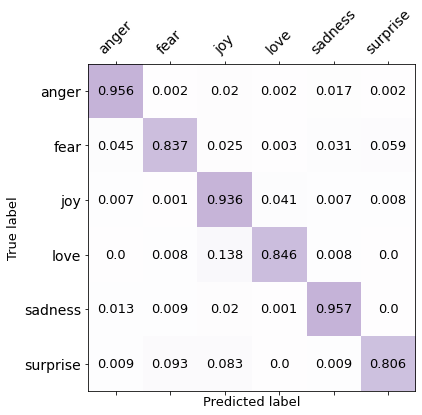

In [27]:
utils.model_evaluate(model, sequence_test, target_test, 32)

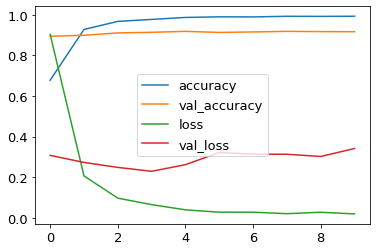

In [28]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

In [29]:
# utils.dump(tokenizer, '/content/drive/MyDrive/__ed__/bilstm_B32/tokenizer.pickle')
# utils.dump(history.history, '/content/drive/MyDrive/__ed__/bilstm_B32/history.pickle')

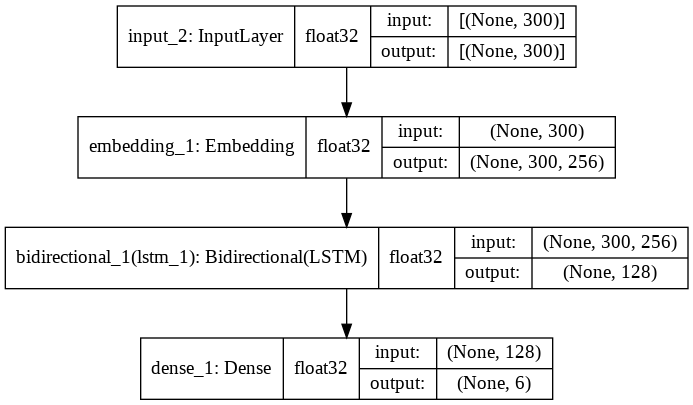

In [30]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/bilstm_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )